In [30]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

In [1]:
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import logging
from tqdm.auto import tqdm

from pathlib import Path
from typing import Union, Optional

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

In [2]:
device = torch.device("cuda:0")

In [3]:
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip

In [4]:
SOS_token = 0
EOS_token = 1

In [5]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = len(self.index2word)
        
    def addSentence(self, sentence):
        for word in sentence.split(" "):
            self.addWord(word)
            
    def addWord(self, word):
        if word in self.word2index:
            self.word2count[word] += 1
            return
        self.word2index[word] = self.n_words
        self.word2count[word] = 1
        self.index2word[self.n_words] = word
        self.n_words += 1
    
    def indices_from_sentence(self, sentence):
        return [self.word2index[word] for word in sentence.split(" ")]
    
    def tensor_from_sentence(self, sentence):
        indices = self.indices_from_sentence(sentence)
        indices.append(EOS_token)
        return torch.tensor(indices, dtype=torch.long, device=device).view(-1, 1)

In [6]:
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [7]:
def normalizeString(s):
    """Lowercase, trim, and remove non-letter characters"""
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def setup_logger(exp_dir: Optional[Union[str, Path]] = None):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.handlers.clear()

    c_handler = logging.StreamHandler()
    c_format = logging.Formatter("%(name)s:%(lineno)d - %(levelname)s - %(message)s")
    c_handler.setFormatter(c_format)
    logger.addHandler(c_handler)

    if exp_dir is not None:
        exp_dir = Path(exp_dir)
        f_handler = logging.FileHandler(exp_dir / "learning.log", mode="w")
        f_format = logging.Formatter("%(asctime)s - %(name)s:%(lineno)d - %(levelname)s - %(message)s")
        f_handler.setFormatter(f_format)
        logger.addHandler(f_handler)

In [9]:
EXP_DIR = "./exp/baseline"
# Path(EXP_DIR).mkdir(exist_ok=False, parents=True)
setup_logger(EXP_DIR)

In [10]:
log = logging.getLogger("notebook")

In [11]:
def readLangs(lang1, lang2, reverse=False):
    with open(f"data/{lang1}-{lang2}.txt", "r", encoding="utf-8") as f:
        lines = [line.strip() for line in f]
    pairs = [[normalizeString(s) for s in line.split("\t")] for line in lines]
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang, output_lang = output_lang, input_lang
    return input_lang, output_lang, pairs

In [12]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

In [13]:
def filterPair(p):
    in_sentence, out_sentence = p
    return len(in_sentence.split(" ")) < MAX_LENGTH \
            and len(out_sentence.split(" ")) < MAX_LENGTH \
            and out_sentence.startswith(eng_prefixes)

In [14]:
def prepareData(lang1, lang2, reverse=False):
    in_lang, out_lang, pairs = readLangs(lang1, lang2, reverse)
    log.info(f"Read {len(pairs)} sentence pairs")
    pairs = list(filter(filterPair, pairs))
    log.info(f"Trimmed to {len(pairs)} sentence pairs")
    for in_sentence, out_sentence in pairs:
        in_lang.addSentence(in_sentence)
        out_lang.addSentence(out_sentence)
    log.info(f"Counted words:")
    log.info(f"{in_lang.name}: {in_lang.n_words}")
    log.info(f"{out_lang.name}: {out_lang.n_words}")
    return in_lang, out_lang, pairs

In [15]:
in_lang, out_lang, pairs = prepareData("eng", "fra", True)

notebook:3 - INFO - Read 135842 sentence pairs
notebook:5 - INFO - Trimmed to 10599 sentence pairs
notebook:9 - INFO - Counted words:
notebook:10 - INFO - fra: 4345
notebook:11 - INFO - eng: 2803


In [16]:
print(random.choice(pairs))

['vous etes fort serviable .', 'you re very helpful .']


In [17]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
    
    def forward(self, input_, hidden):
        embedded = self.embedding(input_).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input_, hidden, encoder_outputs):
        embedded = self.embedding(input_).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        attn_weights = F.softmax(self.attn(torch.cat([embedded[0], hidden[0]], 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat([embedded[0], attn_applied[0]], 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.fc(output[0]), dim=1)
        return output, hidden, attn_weights
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
def tensors_from_pair(pair):
    in_sentence, out_sentence = pair
    in_tensor = in_lang.tensor_from_sentence(in_sentence)
    out_tensor = out_lang.tensor_from_sentence(out_sentence)
    return in_tensor, out_tensor

In [21]:
teacher_forcing_ratio = 0.5

In [23]:
def train(in_tensor, target_tensor, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, 
         criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.init_hidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    in_length = in_tensor.shape[0]
    target_length = target_tensor.shape[0]
    
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    for i in range(in_length):
        encoder_output, encoder_hidden = encoder(in_tensor[i], encoder_hidden)
        encoder_outputs[i] = encoder_output[0, 0]
        
    decoder_input = torch.tensor([[SOS_token]], device=device)
    
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    
    for i in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_tensor[i])
        if use_teacher_forcing:
            decoder_input = target_tensor[i]
        else:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()
            if decoder_input.item() == EOS_token:
                break
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

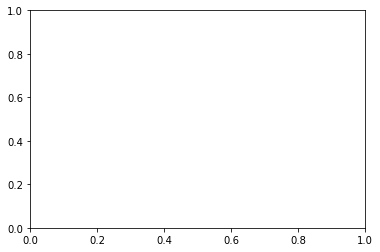

In [24]:
import time
from IPython.display import display, clear_output
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
def show_plot(points):
    clear_output(wait=True)
    ax.cla()
    ax.plot(points)
    display(fig)

In [25]:
def train_iters(encoder, decoder, n_iters,
                print_every=1000, plot_every=100, lr=1e-2):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)
    
    training_pairs = [tensors_from_pair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()
    for i in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[i - 1]
        in_tensor, target_tensor = training_pair
        
        loss = train(in_tensor, target_tensor,
                    encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"{i} of {n_iters}: {print_loss_avg:.4f}")
            
        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            show_plot(plot_losses)
        

In [26]:
hidden_size = 256
encoder1 = EncoderRNN(in_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, out_lang.n_words, dropout_p=0.1).to(device)

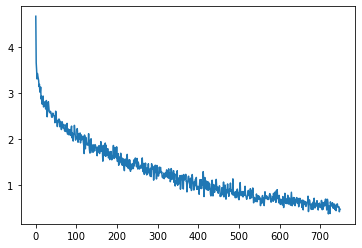

In [27]:
%%time
train_iters(encoder1, attn_decoder1, 75000, print_every=5000)

In [28]:
# add evaluate, evaluate_randomly + show attention

In [46]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        in_tensor = in_lang.tensor_from_sentence(sentence)
        in_length = in_tensor.shape[0]
        encoder_hidden = encoder.init_hidden()
        
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        for i in range(in_length):
            encoder_output, encoder_hidden = encoder(in_tensor[i], encoder_hidden)
            encoder_outputs[i] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for i in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[i] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append("<EOS>")
                break
            else:
                decoded_words.append(out_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
        return decoded_words, decoder_attentions[:i + 1] # ?

In [47]:
def evaluate_randomly(encoder, decoder, n=10):
    for i in range(n):
        in_sencence, ref = random.choice(pairs)
        print(f"> {in_sencence}")
        print(f"= {ref}")
        output_words, attentions = evaluate(encoder, decoder, in_sencence)
        output_sentence = ' '.join(output_words)
        print(f"< {output_sentence}")
        print()

In [48]:
evaluate_randomly(encoder1, attn_decoder1)

> je ne fais que commencer .
= i m just beginning .
< i m just beginning . <EOS>

> nous voyageons avec un budget serre .
= we are traveling on a tight budget .
< we are traveling on a tight budget . <EOS>

> je cherche ma cle .
= i m looking for my key .
< i m looking for my old . <EOS>

> il fait partie de mes amis .
= he is included among my friends .
< he is included among my friends . <EOS>

> nous allons voyager a l etranger cet ete .
= we are going to travel abroad this summer .
< we are going to abroad . <EOS>

> nous sommes toutes ici .
= we re all here .
< we re all here . <EOS>

> je ne prends pas non pour une reponse .
= i m not taking no for an answer .
< i m not taking no for an answer . <EOS>

> nous nous faisons du souci .
= we re worried .
< we are worried . <EOS>

> il est l ami de tout le monde .
= he s everybody s friend .
< he is everybody by everybody . <EOS>

> je me rejouis de vous voir danser .
= i m looking forward to seeing you dance .
< i m looking forward t

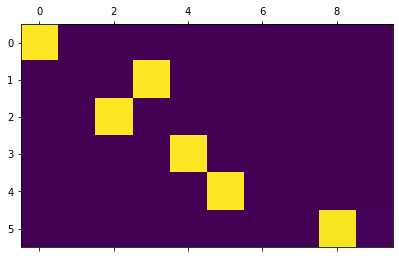

In [49]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

input = elle a cinq ans de moins que moi .
output = she is five years younger than me am <EOS>


/home/artbataev/anaconda3/envs/digitalp/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.
/home/artbataev/anaconda3/envs/digitalp/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


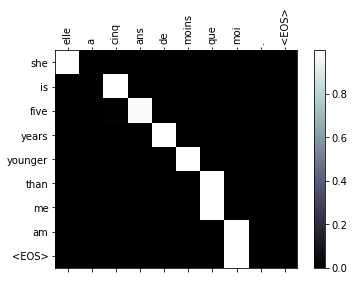

input = elle est trop petit .
output = she s too short . <EOS>


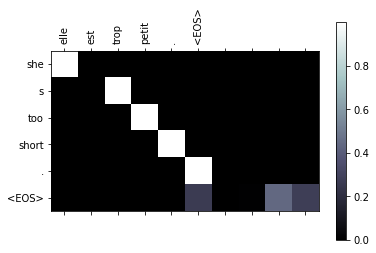

input = je ne crains pas de mourir .
output = i m not afraid of die . <EOS>


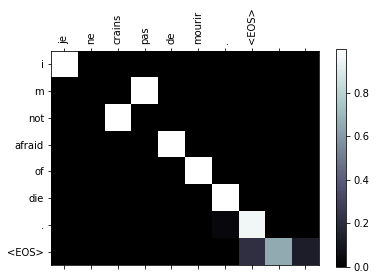

input = c est un jeune directeur plein de talent .
output = he s a talented young guy . <EOS>


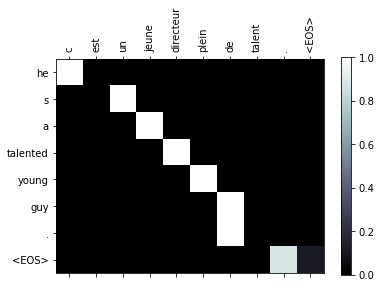

In [50]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")